# Problem Description

1-Data

The data consists of labelled amino acid sequences. Each sequence has a unique ID, the amino acid sequence, the organism it came from and the label. You must predict the label for the test set. Labels consist of one of 20 classes. There are ten organisms, 8 in the training set and 2 in the test set. Sequences above a set length have been excluded from this dataset

2-Objective

Create a model that classify the amino acid sequence

In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time, logging, gc ,os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/instadeep-enzyme-classification-challenge/Train (4).csv
/kaggle/input/instadeep-enzyme-classification-challenge/Test (3).csv
/kaggle/input/instadeep-enzyme-classification-challenge/SampleSubmission (3).csv


In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Embedding, Bidirectional, GlobalMaxPooling1D,LSTM
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense,LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

In [9]:
DIR = '../input/instadeep-enzyme-classification-challenge/'
train=pd.read_csv(DIR+'Train (4).csv')
test=pd.read_csv(DIR+'Test (3).csv')
sub=pd.read_csv(DIR+'SampleSubmission (3).csv')

# EDA

In [10]:
print('Train size: ', len(train))
print('Test size: ', len(test))

Train size:  858777
Test size:  253146


In [11]:
train.head(3)

,SEQUENCE_ID,SEQUENCE,CREATURE,LABEL
0,00011UBJ,MPWQELSITVPHEYVEPISYLFGRYGKGVSTELAGNGQVLLRTYLT...,creature9,class11
1,0001HZ3P,MGKLVIGSRGSELALWQANHIKERLKKECLIESEIQIVKTKGDKIL...,creature3,class13
2,0003NJDO,MFIVAVLMLAFLIFVHELGHFTIARICGVKVEVFSIGFGKKLCFFK...,creature3,class16


In [12]:
train.describe()

,SEQUENCE_ID,SEQUENCE,CREATURE,LABEL
count,858777,858777,858777,858777
unique,858777,816700,8,20
top,00011UBJ,FFRENLAFPEGEAREFPSEQTRAIGPTRGEPQVWGRSSNSLSEAGG...,creature8,class19
freq,1,201,140738,256273


In [13]:
#Check if ther'is null values
train.isnull().sum()

SEQUENCE_ID    0
SEQUENCE       0
CREATURE       0
LABEL          0
dtype: int64

In [14]:
#Remove redundant samples
train=train.drop_duplicates(subset=['SEQUENCE', 'LABEL'], keep='first')

In [15]:
#example of protein sequence
train.SEQUENCE[0]

'MPWQELSITVPHEYVEPISYLFGRYGKGVSTELAGNGQVLLRTYLTTGSRQRMARIDVGVRLVGAIESIGDLIVRELPDDEDWMNSWKSHFKILRVGKRLVIKPTWLELDETIKLDDIVIELDPGIAFGTGYHPTTDTCMQAMEQHITPGMAVLDLGTGSGILAITAMKLGAGKVTALDIDSQAVSAARRNFKRTGISKQIRLGQGSVPHPTAPAAEFDLAVANISARGVVDRCPFILTALKPGALFIASGLLATQKPEVANAVEPLGFSLVSEWPQEEWVTLLYRAPDSPIVASE'

In [16]:
#length of Sequence
train.SEQUENCE.apply(lambda x : len(x)).describe()

count    816950.000000
mean        402.879796
std         208.101618
min          16.000000
25%         262.000000
50%         379.000000
75%         476.000000
max        1234.000000
Name: SEQUENCE, dtype: float64

In [17]:
# Length of sequence in train & test data.
train['seq_count']= train['SEQUENCE'].apply(lambda x: len(x))
test['seq_count']= test['SEQUENCE'].apply(lambda x: len(x))

In [18]:
def plot_seq_count(df, data_name):
  sns.distplot(df['seq_count'].values)
  plt.title(f'Sequence char count: {data_name}')
  plt.grid(True)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


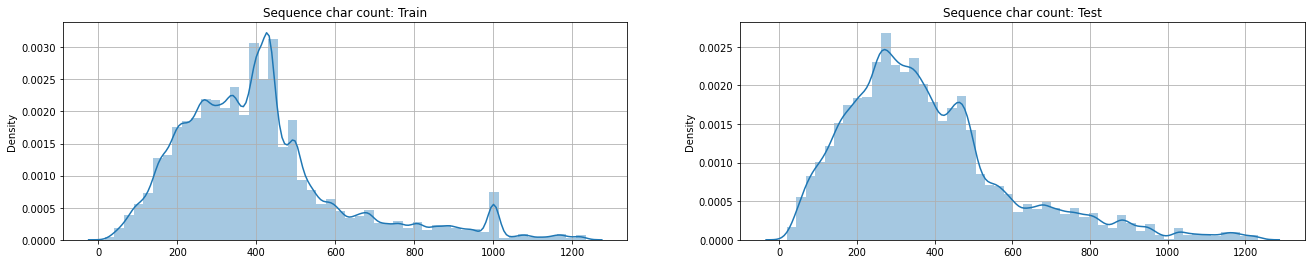

In [19]:
plt.subplot(1, 2, 1)
plot_seq_count(train, 'Train')

plt.subplot(1, 2, 2)
plot_seq_count(test, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

In [20]:
def get_code_freq(df, data_name):
  
  df = df.apply(lambda x: " ".join(x))
  
  codes = []
  for i in df: # concatination of all codes
    codes.extend(i)

  codes_dict= Counter(codes)
  codes_dict.pop(' ') # removing white space
  print(f'Codes: {data_name}')
  print(f'Total unique codes: {len(codes_dict.keys())}')
  df = pd.DataFrame({'Code': list(codes_dict.keys()), 'Freq': list(codes_dict.values())})
  return df.sort_values('Freq', ascending=False).reset_index()[['Code', 'Freq']]

def plot_code_freq(df, data_name):
  plt.title(f'Code frequency: {data_name}')
  sns.barplot(x='Code', y='Freq', data=df)

In [21]:
train_code_freq = get_code_freq(train['SEQUENCE'], 'Train')
train_code_freq

Codes: Train
Total unique codes: 24


,Code,Freq
0,L,33132419
1,A,29148848
2,G,24797034
3,V,22652087
4,E,22130013
5,I,21153868
6,K,19490664
7,D,18311065
8,R,18307046
9,S,17326939


In [22]:
test_code_freq = get_code_freq(test['SEQUENCE'], 'Test')
test_code_freq

Codes: Test
Total unique codes: 22


,Code,Freq
0,L,10305566
1,A,9796485
2,G,7315191
3,V,6659944
4,E,5978780
5,R,5927049
6,D,5447698
7,S,5176983
8,I,5127870
9,T,4790625


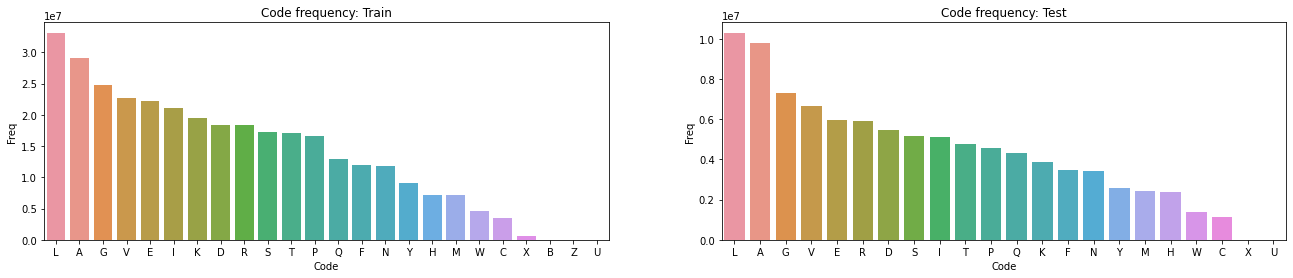

In [23]:
plt.subplot(1, 2, 1)
plot_code_freq(train_code_freq, 'Train')
plt.subplot(1, 2, 2)
plot_code_freq(test_code_freq, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

* amino acids  (X, U, B, Z)  are present in very less quantity
* amino acids  (B, Z) are presented only in the training set 

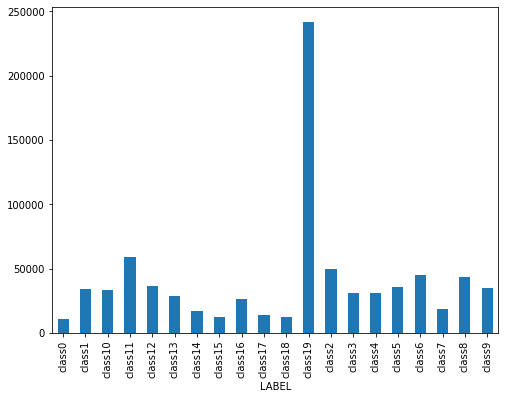

In [24]:
fig = plt.figure(figsize=(8,6))
train.groupby('LABEL').SEQUENCE.count().plot.bar(ylim=0)
plt.show()

* we have unbalanced classes

In [25]:
codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']#,'B',X','U','Z']

def create_dict(codes):
  char_dict = {}
  for index, val in enumerate(codes):
    char_dict[val] = index+1
  return char_dict
char_dict = create_dict(codes)

print(char_dict)
print("Dict Length:", len(char_dict))

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
Dict Length: 20


* We will not consider amino acids that are present in very less quantity

In [26]:
def integer_encoding(data):
  """
  - Encodes code sequence to integer values.
  - 20 common amino acids are taken into consideration
    and rest 4 are categorized as 0.
  """
  
  encode_list = []
  for row in data.values:
    row_encode = []
    for code in row:
      row_encode.append(char_dict.get(code, 0))
    encode_list.append(np.array(row_encode))
  
  return encode_list

In [27]:
#apply label encoding to classes
le = LabelEncoder()
train.LABEL = le.fit_transform(train['LABEL'])

In [28]:
#Split our data into train and validation 
X_train, X_val, y_train, y_val = train_test_split(train.SEQUENCE,train.LABEL, test_size=0.2, random_state=42,stratify=train['LABEL'])

In [29]:
# encode our data
X_train = integer_encoding(X_train) 
X_val = integer_encoding(X_val) 
test_data = integer_encoding(test.SEQUENCE)

In [30]:
#we will take just the first 150 amino acid in the sequence
max_length = 150
train_pad = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
val_pad = pad_sequences(X_val, maxlen=max_length, padding='post', truncating='post')
test_pad = pad_sequences(test_data, maxlen=max_length, padding='post', truncating='post')

train_pad.shape, val_pad.shape, test_pad.shape

((653560, 150), (163390, 150), (253146, 150))

In [31]:
# One hot encoding of label
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_train.shape, y_val.shape

((653560, 20), (163390, 20))

In [32]:
# Detect hardware, return appropriate distribution strategy
print(tf.version.VERSION)
tf.get_logger().setLevel(logging.ERROR)
try: # detect TPU
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPU(s) and enable mixed precision
    strategy = tf.distribute.MirroredStrategy() # works on GPU and multi-GPU
    policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    tf.config.optimizer.set_jit(True) # XLA compilation
    tf.keras.mixed_precision.experimental.set_policy(policy)
    print('Mixed precision enabled')
print("REPLICAS: ", strategy.num_replicas_in_sync)

2.4.1


2023-02-07 01:40:56.849379: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-07 01:40:56.853020: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-07 01:40:56.853089: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-07 01:40:56.853156: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3196bd1c4dd6): /proc/driver/nvidia/version does not exist
2023-02-07 01:40:56.856895: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


In [33]:
if tpu:
    BATCH_SIZE = 128 * strategy.num_replicas_in_sync
else:
    BATCH_SIZE = 64 * strategy.num_replicas_in_sync
BATCH_SIZE

1024

In [34]:
gc.collect()

26750

In [35]:
with strategy.scope():
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(21, 10, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.1,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=0.1)),
    tf.keras.layers.Dense(20, activation='softmax')])

    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(lr=1e-3),
        metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 10)           210       
_________________________________________________________________
bidirectional (Bidirectional (None, 150, 64)           11008     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 20)                1300      
Total params: 37,350
Trainable params: 37,350
Non-trainable params: 0
_________________________________________________________________


In [36]:
es = EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=1)
history = model.fit(train_pad, y_train,epochs=20, batch_size=1024,validation_data=(val_pad,y_val),callbacks=[es])

Epoch 1/20
639/639 [==============================] - 39s 44ms/step - loss: 2.4880 - accuracy: 0.2958 - val_loss: 2.1980 - val_accuracy: 0.3346
Epoch 2/20
639/639 [==============================] - 21s 33ms/step - loss: 2.1173 - accuracy: 0.3600 - val_loss: 1.9092 - val_accuracy: 0.4266
Epoch 3/20
639/639 [==============================] - 21s 33ms/step - loss: 1.8960 - accuracy: 0.4327 - val_loss: 1.7131 - val_accuracy: 0.4941
Epoch 4/20
639/639 [==============================] - 21s 33ms/step - loss: 1.7268 - accuracy: 0.4901 - val_loss: 1.5457 - val_accuracy: 0.5529
Epoch 5/20
639/639 [==============================] - 22s 34ms/step - loss: 1.5987 - accuracy: 0.5344 - val_loss: 1.4299 - val_accuracy: 0.5932
Epoch 6/20
639/639 [==============================] - 21s 33ms/step - loss: 1.4818 - accuracy: 0.5754 - val_loss: 1.3214 - val_accuracy: 0.6302
Epoch 7/20
639/639 [==============================] - 21s 34ms/step - loss: 1.3833 - accuracy: 0.6070 - val_loss: 1.2388 - val_accuracy:

In [37]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.savefig('loss.png')
    plt.show()

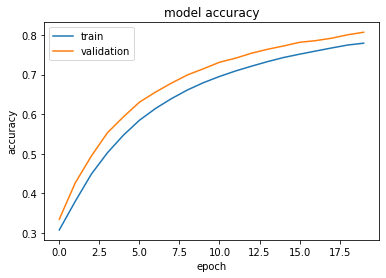

In [38]:
plot_hist(history)

# Evaluating Model on Validation Set

In [39]:
from sklearn.metrics import confusion_matrix, classification_report

In [40]:
len(valid_labels)

NameError: name 'valid_labels' is not defined

In [41]:
pred_valid_y = model.predict(val_pad,  verbose = True)
pred_valid_y_labels = np.argmax(pred_valid_y, axis=-1)
pred_valid_y_labels = le.inverse_transform(pred_valid_y_labels)[:163390]
valid_labels=np.argmax(y_val, axis=-1)
valid_labels=le.inverse_transform(valid_labels)
print(classification_report(valid_labels, pred_valid_y_labels ))

5106/5106 [==============================] - 43s 8ms/step
              precision    recall  f1-score   support

      class0       0.85      0.66      0.74      2126
      class1       0.70      0.75      0.72      6833
     class10       0.85      0.78      0.81      6747
     class11       0.77      0.82      0.79     11839
     class12       0.73      0.71      0.72      7259
     class13       0.81      0.80      0.80      5746
     class14       0.82      0.71      0.76      3404
     class15       0.69      0.65      0.67      2503
     class16       0.75      0.74      0.75      5355
     class17       0.82      0.78      0.80      2842
     class18       0.83      0.74      0.78      2457
     class19       0.86      0.92      0.89     48283
      class2       0.77      0.71      0.74      9933
      class3       0.81      0.76      0.79      6170
      class4       0.76      0.70      0.73      6184
      class5       0.82      0.86      0.84      7219
      class6       0.71

In [42]:
print(confusion_matrix(valid_labels, pred_valid_y_labels ))

[[ 1410    64    62    64    37    13    12     9    13    13     9   167
     41    21    25    17    54     2    34    59]
 [   13  5093    49   181    76    52    28    26    44    65    25   391
    147    55    74    80   252    11    56   115]
 [   43   145  5232   120    55    62    19    21    30    18    66   315
     66    36    72    38   223    14   124    48]
 [    6   156    55  9745   141    81    45    43    47    36    44   543
    206    93    89   132   171    15   117    74]
 [    6    80     9   202  5174    76    37    44   102    14     4   813
    176    81    63   102    74    77    77    48]
 [    9    71    46   104   106  4592    19     7    25    14    12   351
     82    34    37    24    82    54    49    28]
 [   10    50    27    86    46    29  2423    38    28    15     6   238
     68    27    78    31    93     1    38    72]
 [    2    45    15    84    37    12    16  1616    63    36    23   168
     65    35    40    60   106     7    28    45]


<p style='font-size:25px;font-weight:bold'>Please If you find this kernel helpful, upvote it to help others see it 😊</p>